```{index} single: application; regression
```
```{index} single: solver; HiGHS
```
```{index} single: Pyomo; RangeSet
```
```{index} single: Pyomo; decorators
```
```{index} single: sklearn
```
```{index} single: application; regression
```

# 2.2 Least Absolute Deviation (LAD) Regression

Linear regression is a supervised machine learning technique that dates back to at least the 19th century. It remains a cornerstone of modern data analysis, generating a linear model that predicts the values of a dependent variable based on one or more independent variables. This notebook introduces an alternative approach to traditional linear regression, employing linear optimization to optimize based on the Least Absolute Deviation (LAD) metric. 

Unlike standard techniques that aim to minimize the sum of squared errors, this LAD-based method focuses on minimizing the sum of absolute differences between observed and estimated values. This corresponds to considering the $L_1$ norm of the errors, which is known for its robustness against outliers. The methodology presented here follows closely this [survey paper](https://www.jstor.org/stable/1402501) by Subash Narula and John Wellington.

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [2]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

## Generate and visualize data

The Python [scikit learn](https://scikit-learn.org/stable/) library for machine learning provides a full-featured collection of tools for regression. The following cell uses `make_regression` from scikit learn to generate a synthetic data set for use in subsequent cells. The data consists of a numpy array `y` containing `n_samples` of one dependent variable $y$, and an array `X` containing `n_samples` observations of `n_features` independent explanatory variables.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression

n_features = 1
n_samples = 1000
noise = 30

np.random.seed(2021)
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

Before going further, it is generally useful to prepare an initial visualization of the data. The following cell presents a scatter plot of $y$ versus $x$ for the special case of one explanatory variable, and a histogram of the difference between $y$ and the mean value $\bar{y}$. This histogram will provide a reference against which to compare the residual error in $y$ after regression.

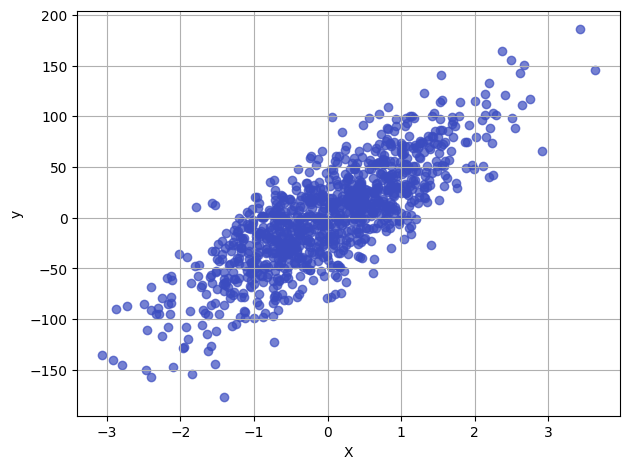

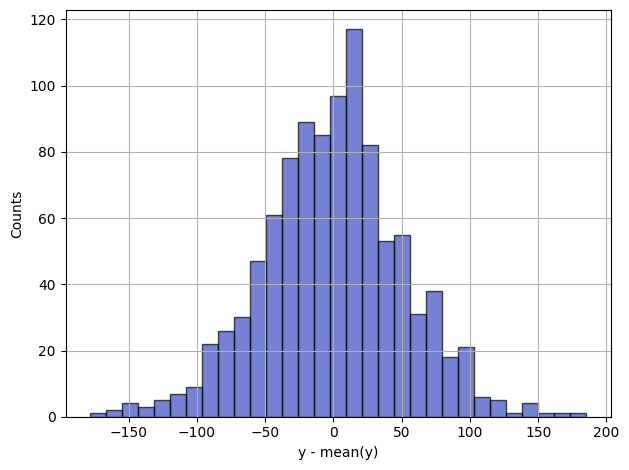

In [4]:
if n_features == 1:
    fig, ax = plt.subplots()
    ax.scatter(X, y, alpha=0.7, color=plt.get_cmap("coolwarm")(0))
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

fig2, ax2 = plt.subplots()
ax2.hist(
    y - np.mean(y),
    bins=int(np.sqrt(len(y))),
    color=plt.get_cmap("coolwarm")(0),
    alpha=0.7,
    edgecolor="black",
)
ax2.set_ylabel("Counts")
ax2.set_xlabel("y - mean(y)")
ax2.grid(True)
plt.tight_layout()
plt.show()

## Model

Suppose that we have a finite dataset consisting of $n$ points $\{({X}^{(i)}, y^{(i)})\}_{i=1,\dots,n}$ with ${X}^{(i)} \in \mathbb{R}^k$ and $y^{(i)} \in \mathbb{R}$. A linear regression model assumes the relationship between the vector of $k$ regressors ${X}$ and the dependent variable $y$ is linear. This relationship is modeled through an error or deviation term $e_i$, which quantifies how much each of the data points diverge from the model prediction and is defined as follows:

$$
\begin{equation}
    e_i:= y^{(i)} - {m}^\top {X}^{(i)} - b = y^{(i)} - \sum_{j=1}^k X^{(i)}_j m_j - b,
\end{equation}
$$

for some real numbers $m_1,\dots,m_k$ and $b$.

The Least Absolute Deviation (LAD) is a possible statistical optimality criterion for such a linear regression. Similarly to the well-known least-squares technique, it attempts to find a vector of linear coefficients ${m}=(m_1,\dots,m_k)$ and intercept $b$ so that the model closely approximates the given set of data. The method minimizes the sum of absolute errors, that is, $\sum_{i=1}^n \left |e_i \right|$.

The LAD regression is formulated as an optimization problem with the intercept $b$, the coefficients $m_i$'s, and the errors $e_i$'s as decision variables, namely

$$
\begin{align}
    \min \quad & \sum_{i=1}^n |e_i| \\
    \text{s.t.} \quad & e_i = y^{(i)} - {m}^\top {X}^{(i)} - b & \forall\, i=1,\dots,n,\\
    & e_i \in \mathbb{R} & \forall\, i=1,\dots,n,\\
    & m_j \in \mathbb{R} & \forall\, j=1,\dots,k,\\
    & b \in \mathbb{R}.
\end{align}
$$

In general, the appearance of an absolute value term indicates the problem is nonlinear and, worse, that the objective function is not differentiable when any $e_i = 0$. However, for this case where the objective is to minimize a sum of absolute errors, one can reformulate the decision variables to transform this into a linear problem. More specifically, introducing for every term $e_i$ two new variables $e_i^-, e_i^+ \geq 0$, we can rewrite the model as

$$
\begin{align}
    \min \quad & \sum_{i=1}^n ( e_i^+ + e_i^-) \\
    \text{s.t.} \quad & e_i^+ - e_i^- = y^{(i)} - {m}^\top {X}^{(i)}-b & \forall\, i=1, \dots, n,\\
    & e_i^+, e_i^- \geq 0 & \forall\, i=1, \dots, n,\\
    & m_j \in \mathbb{R} & \forall\, j=1,\dots,k,\\
    & b \in \mathbb{R}.
\end{align}
$$

The following cell provides a direct implementation of LAD regression.

In [7]:
def lad_regression(X, y):
    model = pyo.ConcreteModel("LAD Regression")

    # get dimensions of data
    n, k = X.shape

    # create index sets (note use of Python style zero based indexing)
    model.I = pyo.RangeSet(0, n - 1)
    model.J = pyo.RangeSet(0, k - 1)

    # create variables
    model.ep = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.em = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.m = pyo.Var(model.J)
    model.b = pyo.Var()

    # constraints
    @model.Constraint(model.I)
    def residuals(m, i):
        return m.ep[i] - m.em[i] == y[i] - sum(X[i][j] * m.m[j] for j in m.J) - m.b

    # objective
    @model.Objective(sense=pyo.minimize)
    def sum_of_abs_errors(m):
        return sum(m.ep[i] + m.em[i] for i in m.I)

    SOLVER.solve(model)

    return model


model = lad_regression(X, y)
print(
    f"Optimal solution: m = {[f'{model.m[j].value:.2f}' for j in model.J][0]} and b = {model.b.value:.2f}"
)
print(f"Objective value: {pyo.value(model.sum_of_abs_errors):.2f}")

Optimal solution: m = 39.66 and b = 1.14
Objective value: 24276.10


In the above code we used Pyomo's `RangeSet' component to define a set that consists of a range of numerical values. It is a convenient way to specify indices for decision variables, constraints, and other model components. Note that, unlike Python's native range function, RangeSet is inclusive of both the start and end values.

## Visualizing the results

If we have a model with a single feature, we can show in the same plot both the original data points (as blue dots) and the fitted model (as a red line) obtained using the optimal coefficients $m$ and $b$ found above. This is useful for visualizing how well the model fits the data. 

In a second plot is generated that displays a histogram of residuals, calculated as the difference between the actual values `y` and the fitted values `y_fit`. The histogram provides insights into the distribution of errors, which is important for model evaluation.

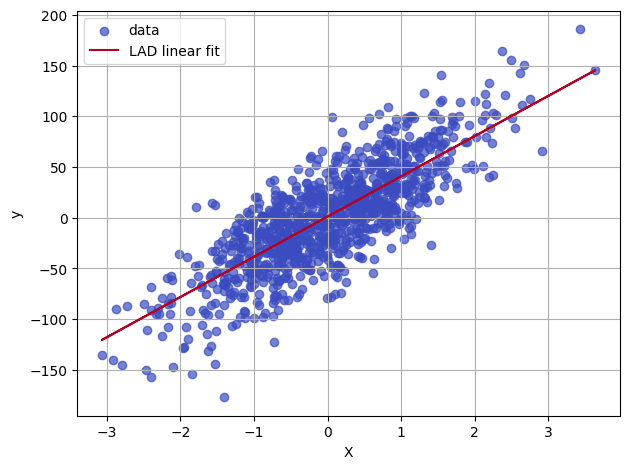

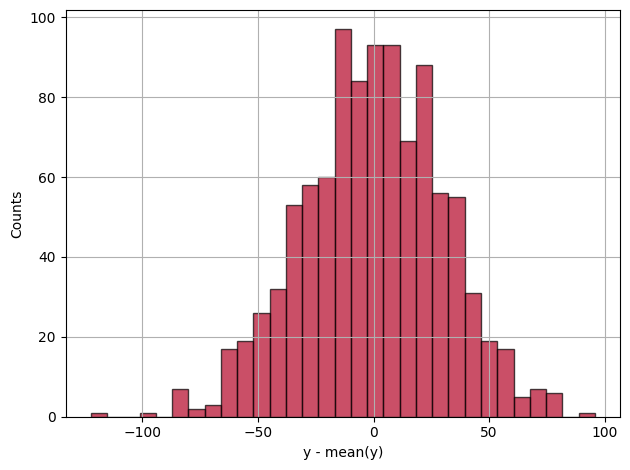

In [8]:
y_fit = np.array([sum(x[j] * model.m[j]() for j in model.J) + model.b() for x in X])

if n_features == 1:
    fig, ax = plt.subplots()
    ax.scatter(X, y, alpha=0.7, color=plt.get_cmap("coolwarm")(0), label="data")
    ax.plot(X, y_fit, color=plt.get_cmap("coolwarm")(1.0), label="LAD linear fit")
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

fig2, ax2 = plt.subplots()
ax2.hist(
    y - y_fit,
    bins=int(np.sqrt(len(y))),
    color=plt.get_cmap("coolwarm")(1.0),
    alpha=0.7,
    edgecolor="black",
)
ax2.set_ylabel("Counts")
ax2.set_xlabel("y - mean(y)")
ax2.grid(True)
plt.tight_layout()
plt.show()